# Crop spatial adata + tissue image: 20191205_10XVisium_MouseBrainCoronal_giovanni.palla 
- need to crop img, adata.uns['spatial'] hires, lowres
- modify adata,obsm['spatial']

In [3]:
import os
import squidpy as sq
import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import tifffile
import pathlib

In [5]:
# set path to data here
BASE_PATH = pathlib.Path(
    "/Users/giovanni.palla/dataset_raw_icb/20201214_SquidpyData_giovanni.palla"
)
DATA_PATH = "VisiumHnE/20191205_10XVisium_MouseBrainCoronal_giovanni.palla"

outdir = os.path.expanduser('/Users/giovanni.palla/Datasets/tutorial_data/')

In [6]:
# load data
img = sq.im.ImageContainer(os.path.join(BASE_PATH / DATA_PATH, 'V1_Adult_Mouse_Brain_image.tif'))
adata = sc.read(os.path.join(outdir, 'visium_hne.h5ad'))


/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [7]:
hires = adata.uns['spatial']['V1_Adult_Mouse_Brain']['images']['hires']
lowres = adata.uns['spatial']['V1_Adult_Mouse_Brain']['images']['lowres']

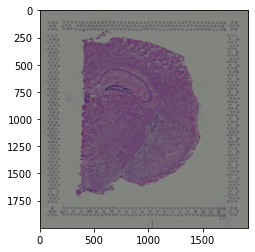

In [8]:
plt.imshow(hires)

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_string_dtype(df[key]) and not is_categorical(df[key])


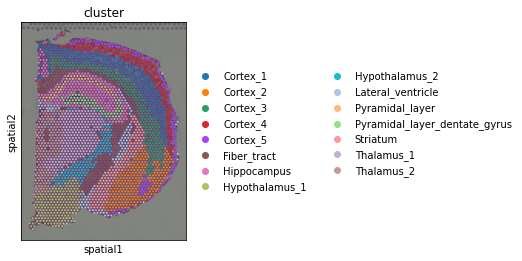

In [9]:
sc.pl.spatial(adata, color='cluster')

In [10]:
def crop(arr, x, y, xs, ys):
    return arr[y:y+ys, x:x+xs]

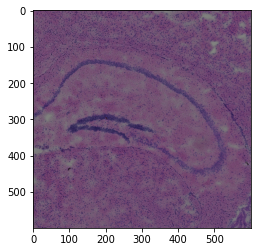

In [11]:
# define crop coords on hires png image
x = 500
y = 400
xs = 600
ys = 600

# confirm that looks ok
plt.imshow(crop(hires, x, y, xs, ys))


In [12]:
# calculate coords for cropping tiff image
sf_hr = adata.uns['spatial']['V1_Adult_Mouse_Brain']['scalefactors']['tissue_hires_scalef']
sf_lr = adata.uns['spatial']['V1_Adult_Mouse_Brain']['scalefactors']['tissue_lowres_scalef']
x = round(500 / sf_hr)
y = round(400 / sf_hr)
xs = round(600 / sf_hr)
ys = round(600 / sf_hr)

print(x, y, xs, ys)

2939 2351 3527 3527


## Crop tiff timage

In [13]:
# crop tiff image
img_cropped = img.crop_corner(x, y, xs, ys)

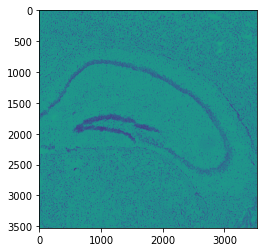

In [14]:
plt.imshow(img_cropped['image'][:,:,0])

In [15]:
# save cropped image

arr = img_cropped['image'].values

tifffile.imsave(os.path.join(outdir, 'visium_hne_crop.tiff'), arr)

In [16]:
# load image and confirm that shape is ok
test_img_cropped = sq.im.ImageContainer(os.path.join(outdir, 'visium_hne_crop.tiff'))

ImageContainer object with 1 layer(s)
    image: y (3527), x (3527), channels (3)



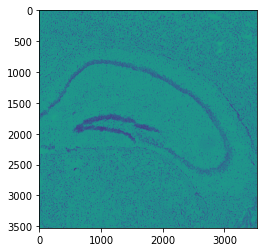

In [17]:
print(test_img_cropped)
plt.imshow(img_cropped['image'][:,:,0])

## Get mask for obs (spots) and crop adata

In [18]:
d = adata.uns['spatial']['V1_Adult_Mouse_Brain']['scalefactors']['spot_diameter_fullres']

In [19]:
# ensure that have a small gap (of size spot diameter) to the border of the image
x_mask = (adata.obsm['spatial'][:,0] < x + xs - d) & (adata.obsm['spatial'][:,0] > x + d)
y_mask = (adata.obsm['spatial'][:,1] < y + ys - d) & (adata.obsm['spatial'][:,1] > y + d)
mask = x_mask & y_mask

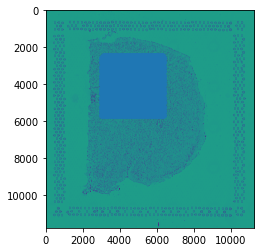

In [20]:
# plot remaining spots
plt.imshow(img['image'][:,:,0])
plt.scatter(adata.obsm['spatial'][mask][:,0], adata.obsm['spatial'][mask][:,1]) 

In [21]:
# points cover the expected area
# mask adata
adata_cropped = adata[mask].copy()

/Users/giovanni.palla/miniconda3/envs/spatial/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


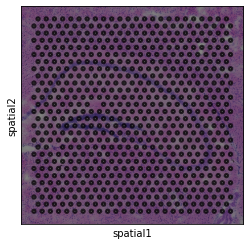

In [22]:
sc.pl.spatial(adata_cropped, add_outline=True)

In [23]:
# modify spatial coordinates in adata_cropped
adata_cropped.obsm['spatial'] = adata_cropped.obsm['spatial'] - [x, y]

## Crop hires and lowres pngs and save in adata_cropped

In [24]:
hires_cropped = crop(hires, round(x*sf_hr), round(y*sf_hr), round(xs*sf_hr), round(ys*sf_hr))
lowres_cropped = crop(lowres, round(x*sf_lr), round(y*sf_lr), round(xs*sf_lr), round(ys*sf_lr))

In [25]:
adata_cropped.uns['spatial']['V1_Adult_Mouse_Brain']['images']['hires'] = hires_cropped
adata_cropped.uns['spatial']['V1_Adult_Mouse_Brain']['images']['lowres'] = lowres_cropped

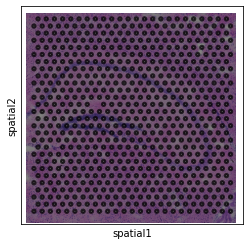

In [26]:
sc.pl.spatial(adata_cropped, add_outline=True, img_key='hires')

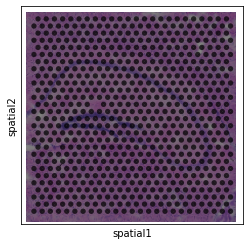

In [27]:
sc.pl.spatial(adata_cropped, add_outline=True, img_key='lowres')

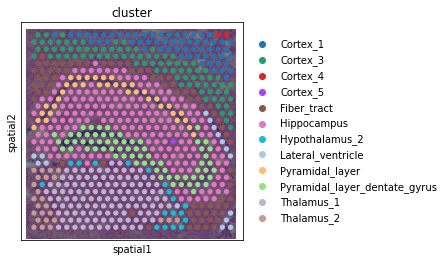

In [29]:
sc.pl.spatial(adata_cropped,color="cluster")

In [30]:
# save adata
adata_cropped.write(os.path.join(outdir, 'visium_hne_crop.h5ad'))